<a href="https://colab.research.google.com/github/Gremling-Machine-Learning-Study-Group/Solucao-das-Equacoes-de-Einstein-com-Machine-Learning/blob/main/exemplo_buraco_negro_regular_tipo_phantom_deepxde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalar pacotes:

In [ ]:
!pip install deepxde

Importar bibliotecas:

In [ ]:
import deepxde as dde
import numpy as np

Physics-informed Neural Networks:

Compiling model...
Building feed-forward neural network...
'build' took 0.054207 s

'compile' took 0.603133 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric   
0         [2.27e-02, 1.60e+01, 3.03e+01]    [2.20e-02, 1.60e+01, 3.03e+01]    [1.09e+00]    
1000      [1.07e-03, 8.85e-06, 3.93e-06]    [5.08e-04, 8.85e-06, 3.93e-06]    [1.24e-01]    
2000      [4.90e-04, 3.40e-06, 1.85e-06]    [3.56e-04, 3.40e-06, 1.85e-06]    [1.08e-01]    
3000      [1.78e-04, 1.02e-06, 6.31e-07]    [3.84e-04, 1.02e-06, 6.30e-07]    [9.76e-02]    
4000      [2.42e-05, 1.26e-07, 6.51e-07]    [4.88e-04, 1.26e-07, 6.51e-07]    [8.79e-02]    
5000      [1.30e-05, 3.07e-08, 1.54e-04]    [5.00e-04, 3.08e-08, 1.54e-04]    [8.24e-02]    
6000      [2.65e-06, 7.33e-09, 3.06e-09]    [5.34e-04, 7.33e-09, 3.11e-09]    [8.35e-02]    
7000      [2.03e-06, 5.60e-09, 5.53e-09]    [5.32e-04, 5.60e-09, 5.68e-09]    [8.30e-02]    
8000   

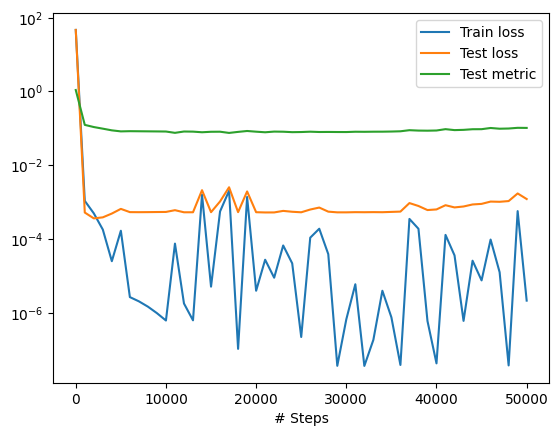

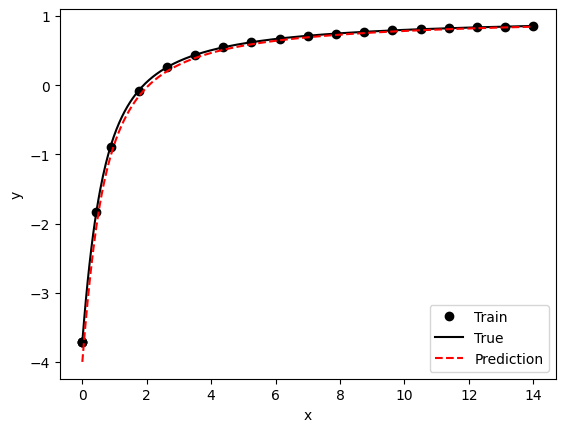

Compiling model...
'compile' took 0.468658 s

Training model...

Step      Train loss                        Test loss                         Test metric   
50000     [7.48e-06, 3.14e-07, 1.75e-06]    [1.21e-01, 3.14e-07, 1.74e-06]    [1.02e-01]    
50054     [1.04e-06, 1.42e-10, 1.10e-10]    [1.21e-01, 1.42e-10, 1.31e-10]    [1.03e-01]    

Best model at step 32000:
  train loss: 3.63e-08
  test loss: 5.31e-04
  test metric: [8.03e-02]

'train' took 3.787160 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


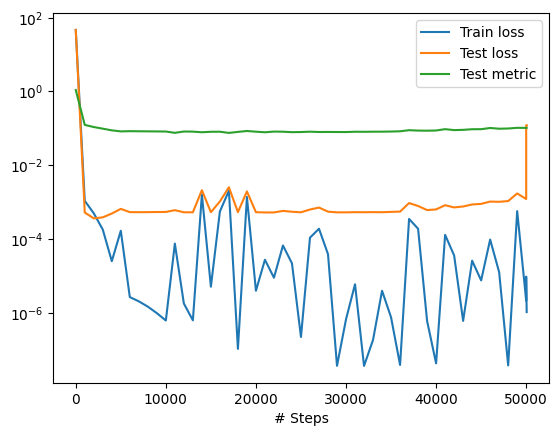

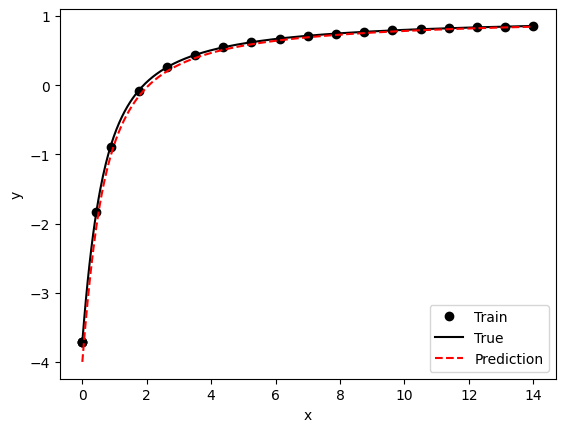

In [9]:
#Definir equação a ser resolvida:
def ode(t, y):
    b=1
    d2y_dt2 = dde.grad.hessian(y, t)
    return (-1) * (t**2 + b**2) * d2y_dt2 + 2 * y -2

#Especificar a funçao exata, caso necessário uma comparação:
def func(t):
    return -(3*np.pi)/(2)-(3*np.pi*t**2)/(2)+(1)/(1+t**2)+(3*t)/(1+t**2)+(t**2)/(1+t**2)+(3*t**3)/(1+t**2)+(3*np.arctan(t))/(1)+(3*np.arctan(t)*t**2)/(1)
#Aqui, t representa a coordenada radial da métrica

#Definir domínio onde a equação será resolvida:
geom = dde.geometry.TimeDomain(0, 14)

#Definir funções para gerar condições de contorno:
def boundary_l(t, on_initial):
    return on_initial and np.isclose(t[0], 0)

def bc_func2(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=None) - 6
#Obs.: A condição inicial da derivada da solução da eq. é 6

#Definir condição inicial:
ic1 = dde.icbc.IC(geom, lambda x: -4, lambda _, on_initial: on_initial)
#Obs.: A condição inicial da solução da eq. é 6

ic2 = dde.icbc.OperatorBC(geom, bc_func2, boundary_l)

#Definir parâmetros da rede neural:
data = dde.data.TimePDE(geom, ode, [ic1, ic2], 16, 2, solution=func, num_test=500)
layer_size = [1] + [100] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

#Definir modelo:
model = dde.Model(data, net)

#Treinar com ADAM:
model.compile(
    "adam", lr=0.001, metrics=["l2 relative error"], loss_weights=[0.01, 1, 1]
)
losshistory, train_state = model.train(iterations=50000)

#Gerar gráfico com as funções do DeepXDE:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

#Treinar com LBFGSB
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS", metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=50000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)
